In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

In [2]:
import glob
vehicles = glob.glob('vehicles/**/*.png')
nonvehicles = glob.glob('non-vehicles/**/*.png')
vehicles2 = glob.glob('vehicles/**/*.PNG') # storing all the images

cars = []
notcars = []

for image in vehicles:
    cars.append(image)
for image in vehicles2:
    cars.append(image)   
for image in nonvehicles:
    notcars.append(image)
print(len(cars))
print(len(notcars))


8841
8968


In [3]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

#Defining bin spatial function to get raw pixel values    
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features
    
# Function to extract features from a list of images
# This function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image1 = mpimg.imread(file)
        image2 = cv2.resize(image1, (64, 64)) # Change extra added images same size of dataset provided by udacity
        image = np.dstack((image2[:,:,0], image2[:,:,1], image2[:,:,2])) # Taking only 3 channels of 4 channel images
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(3):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #Call bin spatial and color histogram for more features
        # Append the new feature vector to the features list
        features1 = bin_spatial(image, size=(16, 16))
        features2 = color_hist(image, nbins=16, bins_range=(0, 256))
        X = np.concatenate((features1, features2, hog_features))
        features.append(X)
        # Return list of feature vectors
    return features

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Applying the scaler to X
scaled_X = X_scaler.transform(X)

# Defining the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Spliting data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Using a linear SVC 
svc = LinearSVC()
# Checking the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Checking the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Checking the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


162.53 Seconds to extract HOG features...
Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6696
5.3 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  0.  0.  0.  0.  1.]
0.00412 Seconds to predict 10 labels with SVC


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


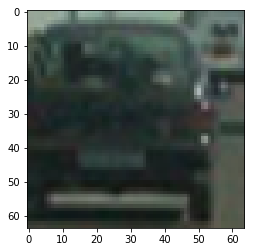

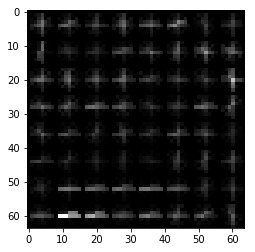

In [6]:
%matplotlib inline
carimage20 = mpimg.imread(cars[20]) # reading 20th car image
feature_image20 = cv2.cvtColor(carimage20, cv2.COLOR_RGB2YCrCb) # converting image to YCrCb

hog_features20, hog_image20 = get_hog_features(feature_image20[:,:,2], orient=10, 
                        pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True) #Extracting hog features with vis = True


plt.figure()
plt.imshow(carimage20)
plt.figure()
plt.imshow(hog_image20, cmap='gray')#Plotting car image and its hog features


In [7]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # covert color function to change colospace of image


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


(720, 1280, 3)


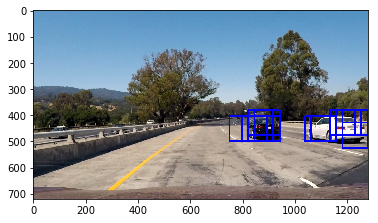

In [12]:
%matplotlib inline
img = mpimg.imread('test_images/test3.jpg') 
X_scaler = StandardScaler().fit(X)
orient = 10
pix_per_cell = 8
cell_per_block = 2
spatial_size = (16, 16)
hist_bins = 16
# Defining a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox_list = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,750:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb') # converting to YCrCb colorspace
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale))) #scaling the image
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    

    # Defining blocks and steps 
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 window size, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Computed individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extracting HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extracting the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Getting color and histogram features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scaling features and making a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left+750, ytop_draw+ystart),(xbox_left+win_draw+750,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left+750, ytop_draw+ystart),(xbox_left+win_draw+750,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img, bbox_list
    
ystart = 380
ystop = 654
scale = 1.5
    
out_img, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.figure()
plt.imshow(out_img)#plotting positive detections on image
print(img.shape)

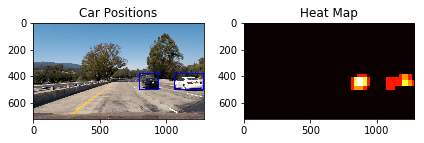

In [13]:
heat = np.zeros_like(img[:,:,0]).astype(np.float) #defing template for add heat 

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image
    return img

heat = add_heat(heat,bbox_list) #added heat for list of bounding boxes
heat = apply_threshold(heat,1) #applying threshhold
heatmap = np.clip(heat, 0, 255) #clipping values above 255 and below 0

from scipy.ndimage.measurements import label
labels = label(heatmap) #applying label functions to get pixels for each car
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout() #plotting heat map and detected cars


In [7]:
import collections
heatmaps = collections.deque(maxlen=50) # defining deque to store 50 heatmaps
def pipeline(image):#Pipeline for video
    X_scaler = StandardScaler().fit(X)
    orient = 10
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (16,16)
    hist_bins = 16
    ystart = 390
    ystop = 656
    scale = 1.5 #setting variables for the function
    out_img, bbox_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    current_heatmap = add_heat(heat, bbox_list) #getting heatmap for current frame
    heatmaps.append(current_heatmap)
    heatmap_sum = sum(heatmaps)#summing 50 heatmaps
    heat90 = apply_threshold(heatmap_sum ,20) #applying threshhold of 20
    heatmap90 = np.clip(heat90, 0, 255)
    from scipy.ndimage.measurements import label
    labels = label(heatmap90)# labeling for each car
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img


In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
output = 'project5_2_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline) 
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project5_2_video.mp4
[MoviePy] Writing video project5_2_video.mp4


100%|█████████▉| 1260/1261 [31:10<00:01,  1.49s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project5_2_video.mp4 

CPU times: user 24min 38s, sys: 6min 55s, total: 31min 34s
Wall time: 31min 11s
